<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/classification_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary modules

In [ ]:
import torch 
from torch import nn
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

## Constants

In [ ]:
n_samples = 1000
random_state = 42

## Make data and visualize it

In [ ]:
X, y = make_circles(n_samples=n_samples, 
                    shuffle=True, 
                    noise=0.03, 
                    random_state=random_state)
pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'label': y}).sample(5)

,X1,X2,label
163,-0.296395,0.774722,1
172,0.199929,0.994300,0
350,-0.633177,0.825978,0
339,0.745617,0.313036,1
760,0.149494,0.990879,0


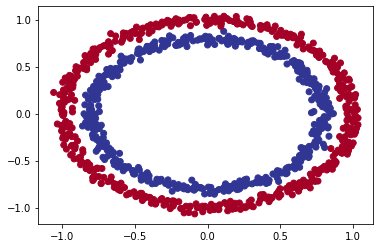

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

## Setting device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Turning data into tensors and splitting into training and testing 

In [ ]:
X = torch.tensor(data=X,
                 requires_grad=False,
                 device=device,
                 dtype=torch.float32)
y = torch.tensor(data=y,
                 requires_grad=False,
                 device=device,
                 dtype=torch.float32)
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]], device='cuda:0')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=random_state,
                                                    train_size=0.8)
X_train.shape

torch.Size([800, 2])

## Creating plot function

In [ ]:
def plot_data(X_train=X_train.cpu(),
              y_train=y_train.cpu(),
              X_test=X_test.cpu(),
              y_test=y_test.cpu(),
              y_pred=None):
    print("Training data:\n\tClass0:Yellow\tClass1:Violet")
    print("Testing data:\n\tClass0:Black\tClass1:Blue")
    plt.figure(figsize=(10,5))
    plt.scatter(x=X_train[:, 0], 
                y=X_train[:, 1], 
                c=y_train, 
                cmap=colors.ListedColormap(['yellow', 'violet']), 
                label="Training data")
    plt.scatter(x=X_test[:, 0], 
                y=X_test[:, 1], 
                c=y_test, 
                cmap=colors.ListedColormap(['black', 'blue']), 
                label="Testing data")
    if y_pred is not None:
        print("Predicted data:\n\tClass0:Red\tClass1:Green")
        plt.title("Data Plot wrt predictions")
        plt.scatter(x=X_test[:, 0], 
                    y=X_test[:, 1], 
                    c=(y_test==y_pred), 
                    cmap=colors.ListedColormap(['red', 'green']),
                    label="Predicted data")
    else:
        plt.title("Data Plot")
    plt.show()

Training data:
	Class0:Yellow	Class1:Violet
Testing data:
	Class0:Black	Class1:Blue


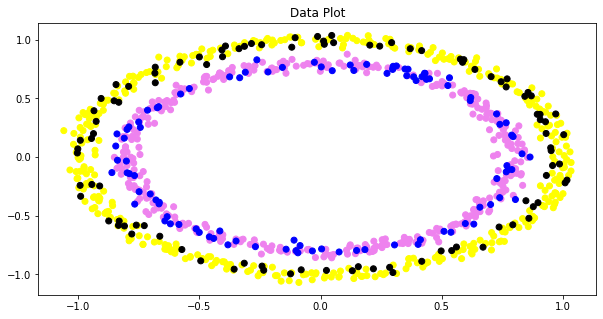

In [ ]:
plot_data()

## Creating the model

In [ ]:
class Classification_Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,
                                       out_features=5,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.linear_layer2 = nn.Linear(in_features=5,
                                       out_features=1,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.linear_layer2(self.linear_layer1(x))


In [ ]:
def accuracy_fn(y_pred=None, y_true=None):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct / len(y_pred))*100

In [ ]:
torch.manual_seed(seed=random_state)

model1 = Classification_Model1()
model1.to(device=device)

model1.state_dict()

OrderedDict([('linear_layer1.weight', tensor([[ 0.1597, -0.6929],
                      [-0.1437, -0.6501],
                      [-0.4861, -0.0248],
                      [ 0.3341, -0.1330],
                      [ 0.0267, -0.3016]], device='cuda:0')),
             ('linear_layer1.bias',
              tensor([ 0.6897, -0.5248,  0.0878,  0.0313,  0.3457], device='cuda:0')),
             ('linear_layer2.weight',
              tensor([[ 0.2915, -0.2569,  0.2050, -0.1601,  0.2281]], device='cuda:0')),
             ('linear_layer2.bias', tensor([0.2054], device='cuda:0'))])

Training data:
	Class0:Yellow	Class1:Violet
Testing data:
	Class0:Black	Class1:Blue
Predicted data:
	Class0:Red	Class1:Green


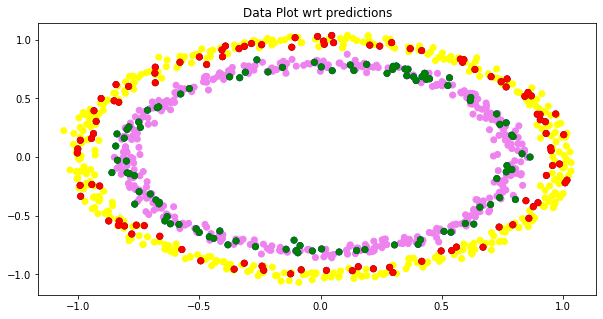

50.0


In [ ]:
# Visualizing model before training 

model1.eval()
with torch.inference_mode():
    predictions = model1(X_test)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions).squeeze()
    plot_data(y_pred=predictions.cpu())
    print(accuracy_fn(y_pred=predictions, y_true=y_test))

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  # Sigmoid function with nn.BCELoss() [Binary Cross Enthropy]

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

epochs = 100

for epoch in range(epochs):
    # Training part 
    model1.train()

    y_logits_train = model1(X_train).squeeze()
    y_pred_train = torch.round(torch.sigmoid(y_logits_train))
    loss_train = loss_fn(y_logits_train, y_train)   # BCEWithLogitsLoss Expects to get input in logits form.

    model1.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch%20 == 0):
        # Testing part
        model1.eval()

        with torch.inference_mode():
            y_logits_test = model1(X_test).squeeze()
            y_pred_test = torch.round(torch.sigmoid(y_logits_test))
            loss_test = loss_fn(y_logits_test, y_test)

        # Displaying data
        acc_train = accuracy_fn(y_pred=y_pred_train,
                                y_true=y_train)
        acc_test = accuracy_fn(y_pred=y_logits_test,
                               y_true=y_test)
        print(f"| Epoch:{epoch}             | Training acc:{acc_train:.3f}  | Testing acc:{acc_test:.3f}")
        print(f"| Training loss:{loss_train:.5f}| Testing loss:{loss_test:.5f} |")
        

| Epoch:0             | Training acc:50.000  | Testing acc:0.000
| Training loss:0.74382| Testing loss:0.73481 |
| Epoch:20             | Training acc:50.000  | Testing acc:0.000
| Training loss:0.70049| Testing loss:0.69835 |
| Epoch:40             | Training acc:52.875  | Testing acc:0.000
| Training loss:0.69475| Testing loss:0.69390 |
| Epoch:60             | Training acc:50.625  | Testing acc:0.000
| Training loss:0.69381| Testing loss:0.69341 |
| Epoch:80             | Training acc:49.875  | Testing acc:0.000
| Training loss:0.69357| Testing loss:0.69343 |


Training data:
	Class0:Yellow	Class1:Violet
Testing data:
	Class0:Black	Class1:Blue
Predicted data:
	Class0:Red	Class1:Green


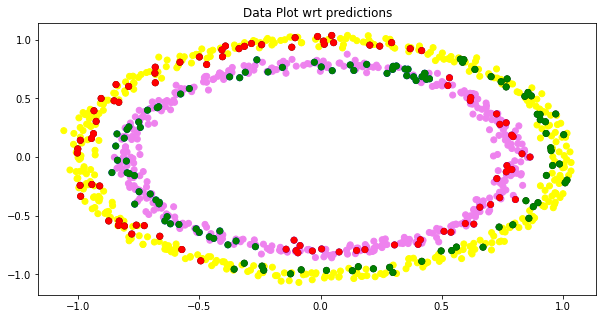

56.00000000000001


In [ ]:
model1.eval()
with torch.inference_mode():
    predictions = model1(X_test)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions).squeeze()
    plot_data(y_pred=predictions.cpu())
    print(accuracy_fn(y_pred=predictions, y_true=y_test))

## Making a new model that uses more layers and more epochs

In [ ]:
class Classification_Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,
                                       out_features=10,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.linear_layer2 = nn.Linear(in_features=10,
                                       out_features=10,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.linear_layer3 = nn.Linear(in_features=10,
                                       out_features=1,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))

model2 = Classification_Model2()
model2.to(device)
model2

Classification_Model2(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

loss_fn = nn.BCEWithLogitsLoss()  # Sigmoid function with nn.BCELoss() [Binary Cross Enthropy]

optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=0.1)

epochs = 1000

for epoch in range(epochs):
    # Training part 
    model2.train()

    y_logits_train = model2(X_train).squeeze()
    y_pred_train = torch.round(torch.sigmoid(y_logits_train))
    loss_train = loss_fn(y_logits_train, y_train)   # BCEWithLogitsLoss Expects to get input in logits form.

    model2.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch%100 == 0):
        # Testing part
        model2.eval()

        with torch.inference_mode():
            y_logits_test = model2(X_test).squeeze()
            y_pred_test = torch.round(torch.sigmoid(y_logits_test))
            loss_test = loss_fn(y_logits_test, y_test)

        # Displaying data
        acc_train = accuracy_fn(y_pred=y_pred_train,
                                y_true=y_train)
        acc_test = accuracy_fn(y_pred=y_pred_test,
                               y_true=y_test)
        print(f"| Epoch:{epoch}             | Training acc:{acc_train:.3f}  | Testing acc:{acc_test:.3f}")
        print(f"| Training loss:{loss_train:.5f}| Testing loss:{loss_test:.5f} |")
        

| Epoch:0             | Training acc:51.375  | Testing acc:53.000
| Training loss:0.69509| Testing loss:0.69669 |
| Epoch:100             | Training acc:50.250  | Testing acc:51.000
| Training loss:0.69336| Testing loss:0.69442 |
| Epoch:200             | Training acc:50.875  | Testing acc:47.500
| Training loss:0.69308| Testing loss:0.69426 |
| Epoch:300             | Training acc:51.000  | Testing acc:47.000
| Training loss:0.69301| Testing loss:0.69437 |
| Epoch:400             | Training acc:51.125  | Testing acc:47.000
| Training loss:0.69299| Testing loss:0.69449 |
| Epoch:500             | Training acc:51.250  | Testing acc:47.000
| Training loss:0.69298| Testing loss:0.69457 |
| Epoch:600             | Training acc:51.250  | Testing acc:46.000
| Training loss:0.69298| Testing loss:0.69462 |
| Epoch:700             | Training acc:51.500  | Testing acc:46.000
| Training loss:0.69298| Testing loss:0.69465 |
| Epoch:800             | Training acc:51.500  | Testing acc:44.500
| Trai

Training data:
	Class0:Yellow	Class1:Violet
Testing data:
	Class0:Black	Class1:Blue
Predicted data:
	Class0:Red	Class1:Green


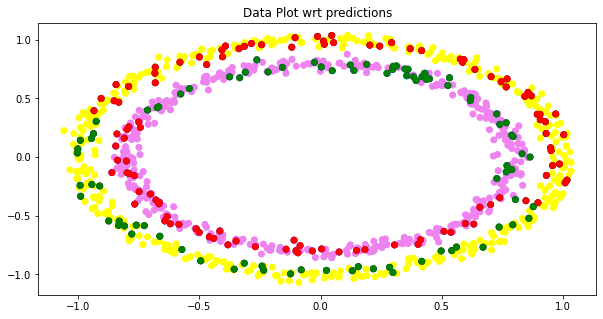

45.0


In [ ]:
model2.eval()
with torch.inference_mode():
    predictions = model2(X_test)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions).squeeze()
    plot_data(y_pred=predictions.cpu())
    print(accuracy_fn(y_pred=predictions, y_true=y_test))

## Introducing non linearity

In [ ]:
class Classification_Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,
                                       out_features=10,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.linear_layer2 = nn.Linear(in_features=10,
                                       out_features=10,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.linear_layer3 = nn.Linear(in_features=10,
                                       out_features=1,
                                       bias=True,
                                       device=device,
                                       dtype=torch.float32)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.linear_layer3(self.relu(self.linear_layer2(self.relu(self.linear_layer1(x)))))

model3 = Classification_Model3()
model3.to(device)
model3

Classification_Model3(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

loss_fn = nn.BCEWithLogitsLoss()  # Sigmoid function with nn.BCELoss() [Binary Cross Enthropy]

optimizer = torch.optim.SGD(params=model3.parameters(),
                            lr=0.1)

epochs = 1000

for epoch in range(epochs):
    # Training part 
    model3.train()

    y_logits_train = model3(X_train).squeeze()
    y_pred_train = torch.round(torch.sigmoid(y_logits_train))
    loss_train = loss_fn(y_logits_train, y_train)   # BCEWithLogitsLoss Expects to get input in logits form.

    model3.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch%100 == 0):
        # Testing part
        model3.eval()

        with torch.inference_mode():
            y_logits_test = model3(X_test).squeeze()
            y_pred_test = torch.round(torch.sigmoid(y_logits_test))
            loss_test = loss_fn(y_logits_test, y_test)

        # Displaying data
        acc_train = accuracy_fn(y_pred=y_pred_train,
                                y_true=y_train)
        acc_test = accuracy_fn(y_pred=y_pred_test,
                               y_true=y_test)
        print(f"| Epoch:{epoch}             | Training acc:{acc_train:.3f}  | Testing acc:{acc_test:.3f}")
        print(f"| Training loss:{loss_train:.5f}| Testing loss:{loss_test:.5f} |")
        

| Epoch:0             | Training acc:50.000  | Testing acc:50.000
| Training loss:0.69681| Testing loss:0.69710 |
| Epoch:100             | Training acc:50.000  | Testing acc:50.000
| Training loss:0.69555| Testing loss:0.69577 |
| Epoch:200             | Training acc:49.625  | Testing acc:50.000
| Training loss:0.69495| Testing loss:0.69520 |
| Epoch:300             | Training acc:45.125  | Testing acc:46.000
| Training loss:0.69454| Testing loss:0.69490 |
| Epoch:400             | Training acc:39.375  | Testing acc:41.500
| Training loss:0.69418| Testing loss:0.69471 |
| Epoch:500             | Training acc:38.250  | Testing acc:41.000
| Training loss:0.69379| Testing loss:0.69450 |
| Epoch:600             | Training acc:44.750  | Testing acc:44.000
| Training loss:0.69318| Testing loss:0.69400 |
| Epoch:700             | Training acc:47.625  | Testing acc:45.000
| Training loss:0.69291| Testing loss:0.69378 |
| Epoch:800             | Training acc:48.875  | Testing acc:46.500
| Trai

Training data:
	Class0:Yellow	Class1:Violet
Testing data:
	Class0:Black	Class1:Blue
Predicted data:
	Class0:Red	Class1:Green


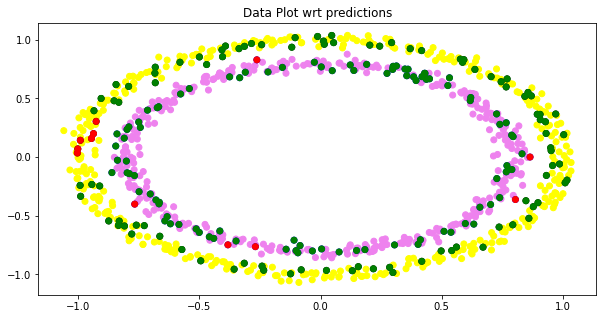

94.0


In [ ]:
model3.eval()
with torch.inference_mode():
    predictions = model3(X_test)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions).squeeze()
    plot_data(y_pred=predictions.cpu())
    print(accuracy_fn(y_pred=predictions, y_true=y_test))

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


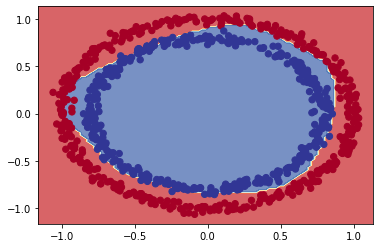

In [ ]:
plot_decision_boundary(model3, X_train, y_train)

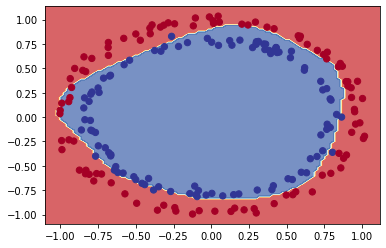

In [ ]:
plot_decision_boundary(model3, X_test, y_test)